In [1]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install pandas 
!pip install matplotlib.pyplot


ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot


In [1]:
!pip install matplotlib
!pip install numpy


In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers

In [2]:
import matplotlib.pyplot as plt

In [34]:
IMAGE_SIZE=256
BATCH_SIZE= 16
CHANNELS=3
EPOCHS=8

In [35]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 15453 files belonging to 16 classes.


In [36]:
class_names=dataset.class_names
class_names


['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Pictures',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [37]:
len(dataset)

966

In [38]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(16, 256, 256, 3)
[15  6  8  6 10 11  8  5  8 13 10  4 15 13  9  9]


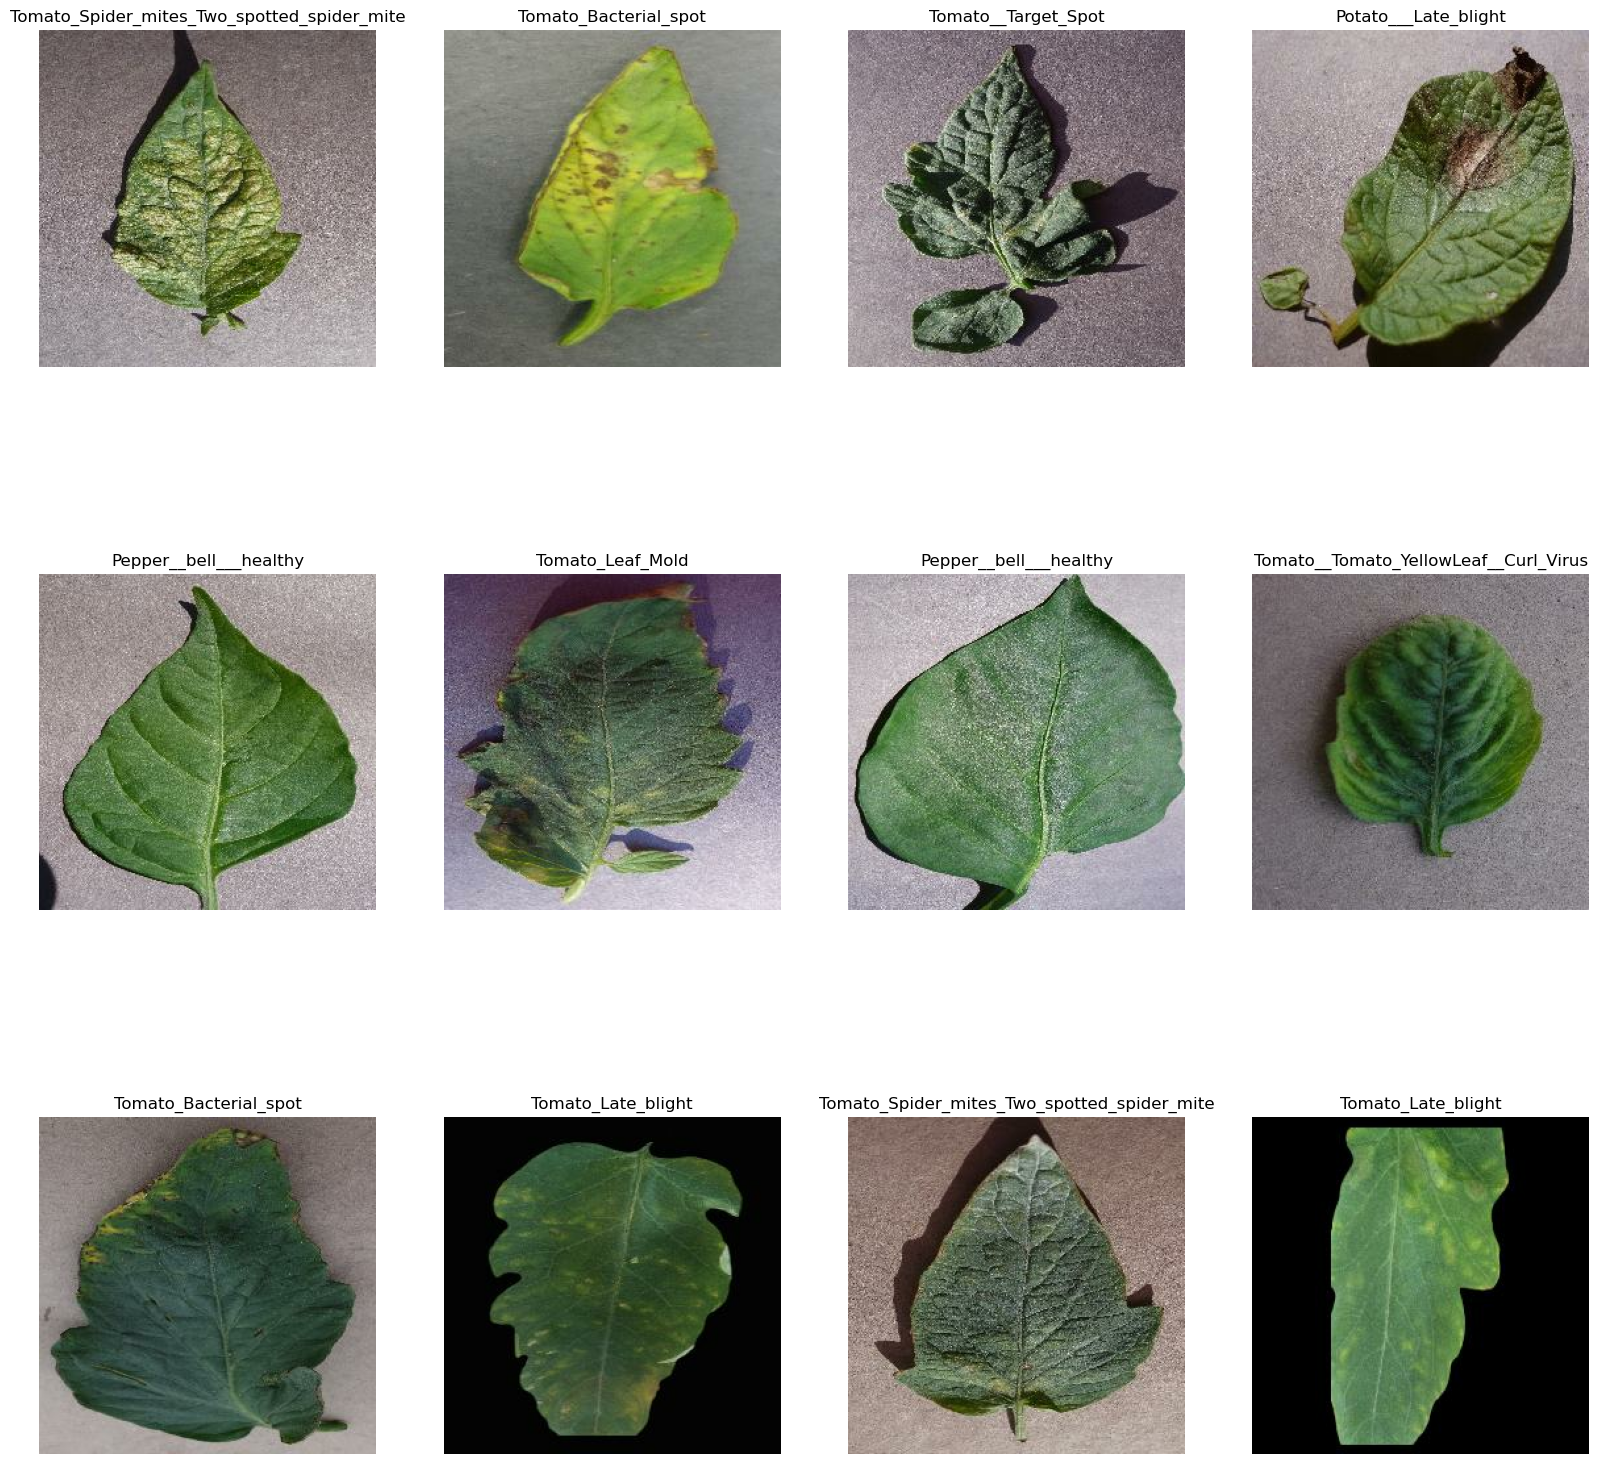

In [39]:
plt.figure(figsize=(20,20))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
         ax = plt.subplot(3,4,i+1)
         plt.imshow(image_batch[i].numpy().astype("uint8"))
         plt.title(class_names[label_batch[i]])
         plt.axis("off")


In [51]:
len(dataset)

966

In [52]:
80% ==> training
20% ==> 10% validation and 10% test

SyntaxError: invalid syntax (1389537312.py, line 1)

In [53]:
train_size=0.8
len(dataset)*train_size

772.8000000000001

In [54]:
train_ds=dataset.take(772)
len(train_ds)

772

In [58]:
test_ds=dataset.skip(772)
len(test_ds)

194

In [59]:
val_size=0.1
len(dataset)*val_size

96.60000000000001

In [60]:
val_ds=test_ds.take(96)
len(val_ds)

96

In [61]:
test_ds=test_ds.skip(96)
len(test_ds)


98

In [62]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size= len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size= int(train_split*ds_size)
    val_size= int(val_split*ds_size)

    train_ds= ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [63]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [64]:
len(train_ds)

772

In [65]:
len(val_ds)

96

In [66]:
len(test_ds)

98

In [67]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [68]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [69]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    
])

In [70]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [71]:
## building the model using cnn

In [72]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications

IMAGE_SIZE = 256
CHANNELS = 3
NUM_CLASSES = 15

base_model = applications.MobileNetV2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    include_top=False,  
    weights='imagenet'  
)

C:\Users\prave\AppData\Local\Temp\ipykernel_12396\3729327722.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(


In [73]:
base_model.trainable = False

In [74]:
model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),

    # Apply Augmentation
    data_augmentation,

    # Rescale pixel values
    layers.Rescaling(1./255),

    # MobileNetV2 Feature Extractor
    base_model,

    # Global Pooling instead of Flatten
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')  # Output layer
])

In [75]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [76]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,921,551 (11.14 MB)

 Trainable params: 663,567 (2.53 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [77]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)


In [1]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=[early_stopping, lr_scheduler]
)


NameError: name 'model' is not defined